<font size="6"> **Portfolio Optimization** </font>

In [1]:
%%capture
%run 00_portopt_data.ipynb

### Load Packages

In [2]:
import cvxpy as cvx
import matplotlib.pyplot as plt

# Statistical Risk Model

In [3]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_var_vector', 'factor_betas', 'factor_returns'])

In [4]:
risk_model['factor_betas'].shape

(490, 20)

In [5]:
risk_model['factor_cov_matrix'] = np.diag(risk_model['factor_var_vector']['0'].values)
risk_model['factor_cov_matrix'].shape

(20, 20)

In [6]:
risk_model['idiosyncratic_var_vector'].shape

(490, 1)

# Create Alpha Factors

In [7]:
# alphas
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed', 'avg_combi_alpha', 'ml_alpha']

In [8]:
alpha_vector = B_alpha.loc[test_start, 'ml_alpha'].reset_index(level=0, drop=True).copy()
pd.concat([alpha_vector.head(2), alpha_vector.tail(2)], axis=0)


asset
A       0.881216
AAL     1.705349
ZION   -0.121301
ZTS     0.428121
Name: ml_alpha, dtype: float64

# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [9]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector, w_prev, tc_lambda):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T @ weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def _combi_series(self, x, y, fill_value=0.0):
        choose_left = lambda x, y: x
        w = x.combine(y, func=choose_left, fill_value=fill_value)
        w = w[y.index]
        
        return w
    
    def _compute_transaction_cost_constant(self, alpha_vector, adv_vector):
        adv_vector_cp = self._combi_series(adv_vector, alpha_vector, fill_value=1.0e4)
        adv_vector_cp = np.clip(adv_vector_cp, a_min=1.0e4, a_max= np.inf)
        
        return  0.1 / adv_vector_cp
    
    def find(self, alpha_vector, w_prev, adv_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        tc_lambda = self._compute_transaction_cost_constant(alpha_vector, adv_vector)
        obj = self._get_obj(weights, alpha_vector, w_prev, tc_lambda)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()

        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [10]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector, w_prev, tc_lambda):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert isinstance(alpha_vector, pd.Series), 'alpha vector must be a pandas Series'
        
        alpha_term = alpha_vector.values.flatten() @ weights
        
        w_pred_pad = self._combi_series(w_prev, alpha_vector, fill_value=0.0)
        w_delta_sq = (weights-w_pred_pad)**2
        trans_cost_term = w_delta_sq @ tc_lambda 

        return cvx.Minimize(-alpha_term + trans_cost_term)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        constraints = [
            risk <= self.risk_cap**2, # risk constraint
            factor_betas.T @ weights <= self.factor_max,  # factor exposures constraints
            factor_betas.T @ weights >= self.factor_min,
            weights <= self.weights_max,  # constraints on allocations
            weights >= self.weights_min,
            cvx.sum(cvx.abs(weights)) <= 1.0,  # leverage
            cvx.sum(weights) == 0.0,  # market neutral
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [11]:
alpha_vector.head(3)

asset
A      0.881216
AAL    1.705349
AAP    0.363903
Name: ml_alpha, dtype: float64

In [12]:
w_prev = pd.Series(index=alpha_vector.index[0:1], data = [0.5])
w_prev

asset
A    0.5
dtype: float64

In [13]:
adv_vector = adv.loc[test_start]
adv_vector.head(3)

A      18241.544692
AAL    10000.000000
AAP    21960.122007
Name: 2015-05-26 00:00:00+00:00, dtype: float64

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


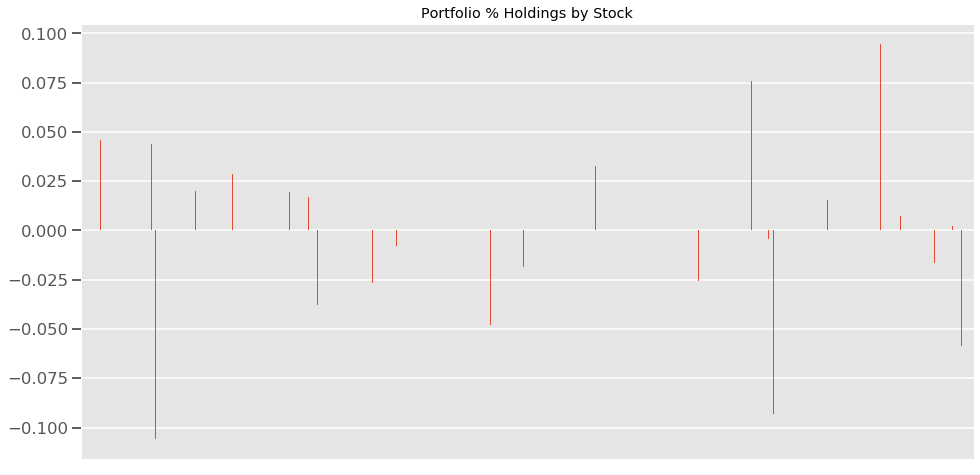

In [14]:
optimal_weights = OptimalHoldings().find(alpha_vector, w_prev, adv_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [15]:
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

In [16]:
dollar_pnl0 = partial_dot_product(v=optimal_weights[0], w=daily_returns.loc[test_start])
dollar_pnl0.sum()

-0.0009541461380288695

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


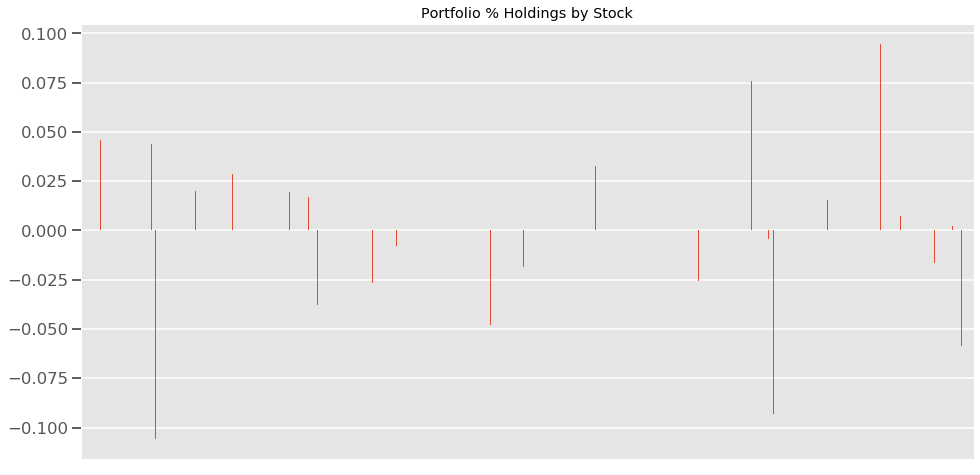

In [17]:
w_prev = pd.Series(index=['FULC'], data = [0])
optimal_weights = OptimalHoldings().find(alpha_vector, w_prev, adv_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [18]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector, w_prev, tc_lambda):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert isinstance(alpha_vector, pd.Series), 'alpha vector must be a pandas Series'
        
        alpha_term = alpha_vector.values.flatten() @ weights
        reg_term = self.lambda_reg * cvx.norm(weights, 2)
                                              
        w_pred_pad = self._combi_series(w_prev, alpha_vector, fill_value=0.0)
        w_delta_sq = (weights-w_pred_pad)**2
        trans_cost_term = w_delta_sq @ tc_lambda 
                                              
        return cvx.Minimize(- alpha_term + reg_term + trans_cost_term)

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


### View Data

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


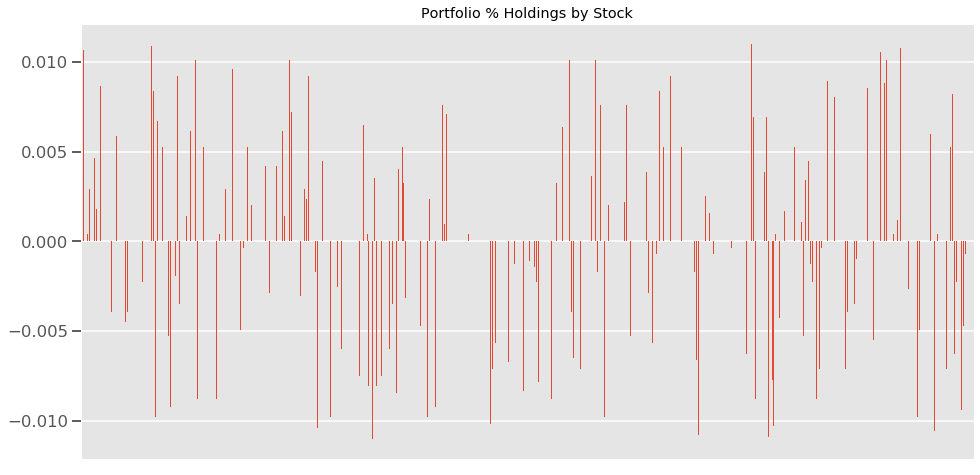

In [19]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector,  w_prev, adv_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [20]:
dollar_pnl1 = partial_dot_product(v=optimal_weights_1[0], w=daily_returns.loc[test_start])
dollar_pnl1.sum()

-0.002749674011882053

Nice. Well diversified.

In [21]:
from src.portfolio_opt import cvx_opt_tc
import datetime as dt

In [23]:
bkt_dt_set = test_dates.unique()
bkt_dt = bkt_dt_set[0]
alpha_factor_name = 'ml_alpha'

alpha_vector = B_alpha.loc[bkt_dt, alpha_factor_name]
adv_vector = adv.loc[bkt_dt]


In [24]:
alpha_vector = B_alpha.loc[test_start, 'ml_alpha'].reset_index(level=0, drop=True).copy()
pd.concat([alpha_vector.head(2), alpha_vector.tail(2)], axis=0)

asset
A       0.881216
AAL     1.705349
ZION   -0.121301
ZTS     0.428121
Name: ml_alpha, dtype: float64

In [25]:
opt = cvx_opt_tc.OptimalHoldingsRegualization(lambda_reg=5.0)
w_opt1 = opt.find(alpha_vector, w_prev, adv_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

In [26]:
np.allclose(w_opt1, optimal_weights_1[0])

True